In [ ]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

import graph_tools
import networkx as nx

def generate_supervoter_graph(n, seed=0):
    """
    Generate a directed graph with a pyramid structure of lots of low confidence nodes, 
    fewer medium confidence nodes, and the fewest high confidence nodes. This simulates a
    scenario where most nodes have low confidence, some have medium, and very few have high confidence
    with a tendency to delegate upwards."""

    if n == 0:
        return nx.DiGraph()

    # Allocate nodes in a pyramid: many Normal, fewer Experts, 1 supervoter
    # Normal people often vote to the supervoter, sometimes to Experts, rarely to other Normals
    # Experts vote themselves, and sometimes to the supervoter, rarely to other Experts
    # Supervoter always votes, never delegates
    supervoter_count = 1 if n >= 1 else 0
    normal_count = int(n * 0.8) if int(n * 0.8) - supervoter_count > 0 else 0
    expert_count = n - normal_count - supervoter_count
    sizes = [normal_count, expert_count, supervoter_count]

    # Delegation tendency matrix: rows = from group, cols = to group
    p_nn = 0.2 / normal_count if normal_count > 0 else 1
    p_ee = 0.2 / expert_count if expert_count > 0 else 1
    p_ne = 0.8 / expert_count if expert_count > 0 else 1 # Each expert will get approx. 0.8 votes from normals
    p = [
        # To: Normal Expert Supervoter
        [p_nn, p_ne, 0.6],   # From Normal
        [0.0 , p_ee, 0.6],    # From Expert
        [0.0 , 0.0 , 0.0],   # From Supervoter (always votes)
    ]
    
    G = nx.stochastic_block_model(sizes, p, directed=True, seed=seed)

    return G

In [91]:
supervoter_graph = generate_supervoter_graph(40, seed=1)
supervoter_graph = graph_tools.nx_graph_nodes_to_str(supervoter_graph)
supervoter_graph = graph_tools.prepare_graph(supervoter_graph.nodes(), supervoter_graph.edges(), sink_frac = 0.0)
delegations_orig = graph_tools.nx_graph_to_dict(supervoter_graph)

viz.visualize_delegation_graph(delegations_orig)

print(list(nx.strongly_connected_components(supervoter_graph)))

Parsing the data...Done
Parsing the data...Done
Parsing the data...Done


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.
Address already in use
Port 8051 is in use by another program. Either identify and stop that program, or start the server with a different port.


Graph visualization failed because no ports were found or there was another error.
[{'39'}, {'36'}, {'31'}, {'14'}, {'0'}, {'33'}, {'1'}, {'30'}, {'38'}, {'2'}, {'35'}, {'3'}, {'4'}, {'5'}, {'37'}, {'6'}, {'7'}, {'8'}, {'32'}, {'34'}, {'9'}, {'10'}, {'11'}, {'12'}, {'13'}, {'15'}, {'19'}, {'16'}, {'17'}, {'18'}, {'20'}, {'21'}, {'22'}, {'23'}, {'24'}, {'25'}, {'26'}, {'27'}, {'28'}, {'29'}]


No trigger


In [60]:
# to guage how often cycles appear in these graphs
for seed in range(10):
    i_s = []
    for i in range(200):
        supervoter_graph = generate_supervoter_graph(i, seed=seed)
        supervoter_graph = graph_tools.nx_graph_nodes_to_str(supervoter_graph)
        delegation_graph = graph_tools.prepare_graph(supervoter_graph.nodes(), supervoter_graph.edges(), 0.0)
        if "lost" in delegation_graph:
            i_s.append(i)
    if i_s:
        print(f"Seed {seed}: {i_s}")


Seed 1: [8, 168]
Seed 2: [198]
Seed 4: [159]
Seed 5: [27]
Seed 6: [128, 168]
Seed 7: [23]


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000


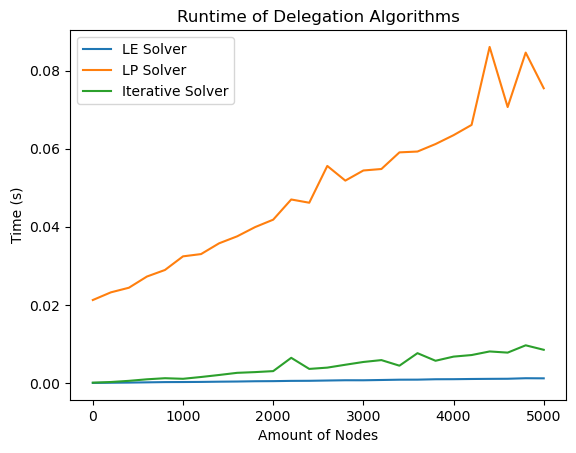

In [89]:
range_x = range(0, 5001, 200)

time_data_le = []
time_data_lp = []
time_data_iterative = []
cycles = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        supervoter_graph = generate_supervoter_graph(num_nodes)
        supervoter_graph = graph_tools.nx_graph_nodes_to_str(supervoter_graph)
        delegation_graph = graph_tools.prepare_graph(supervoter_graph.nodes(), supervoter_graph.edges(), 0.0)
        nodes = list(delegation_graph)
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
        delegations = graph_tools.invert_graph(delegations_orig)

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 10
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 2000:
            n = 50

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

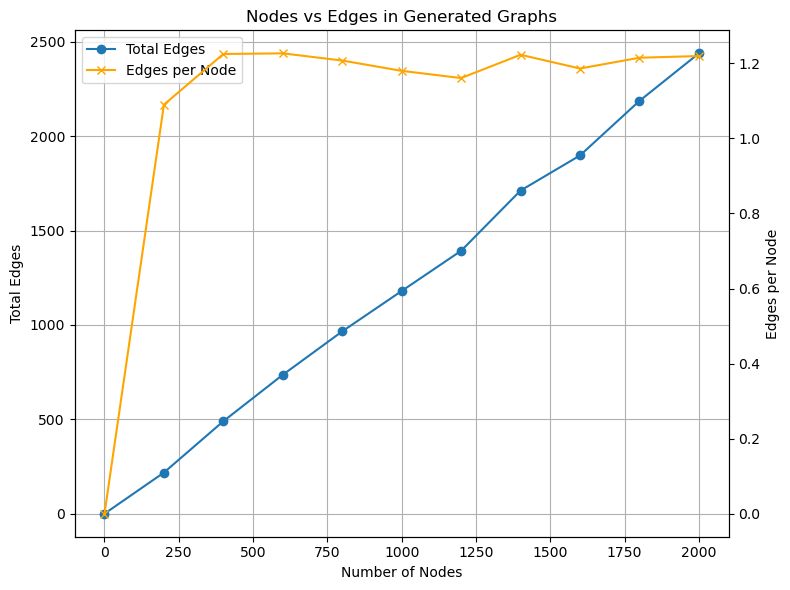

In [86]:
def generate_graph(num_nodes):
    stochastic_block_model_graph = generate_supervoter_graph(num_nodes)
    stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
    return graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)

node_counts = []
edge_counts = []
edges_per_node_counts = []

for i in range(0, 2001, 200): 
    G = generate_graph(i)
    node_counts.append(G.number_of_nodes())
    edge_counts.append(G.number_of_edges())
    edges_per_node_counts.append(G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot total edges on the left y-axis
ax1.plot(node_counts, edge_counts, marker='o', label='Total Edges')
ax1.set_xlabel("Number of Nodes")
ax1.set_ylabel("Total Edges")
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(node_counts, edges_per_node_counts, marker='x', label='Edges per Node', color='orange')
ax2.set_ylabel("Edges per Node")
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Nodes vs Edges in Generated Graphs")
ax1.grid(True)
fig.tight_layout()
plt.show()
